
# Lab 11 — Proyecto de Consultoría: **Regresión Logística para Abandono de Clientes (Churn)**


In [3]:

# ===== 1) Imports básicos =====
import os
import sys
import math
import json
import warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, average_precision_score)
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



## 2) Carga de datos

In [6]:

# Intenta cargar los archivos entregados.
hist_path = 'abandono_clientes.csv'   # histórico etiquetado
new_path  = 'clientes_nuevos.csv'     # clientes futuros


df = pd.read_csv(hist_path)
print('Histórico (primeras filas):')
display(df.head())


df_new = pd.read_csv(new_path)
print('Nuevos (primeras filas):')
display(df_new.head())

print('\nDimensiones — histórico:', df.shape)
if df_new is not None:
    print('Dimensiones — nuevos:', df_new.shape)


Histórico (primeras filas):


,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


Nuevos (primeras filas):


,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,NaN
Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,NaN
Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,NaN
Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,NaN
Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,NaN



Dimensiones — histórico: (900, 10)
Dimensiones — nuevos: (6, 9)


## 3) Exploración rápida y verificación de columnas

In [7]:

print('Columnas histórico:', list(df.columns))
target_col_candidates = [c for c in df.columns if c.lower() == 'churn']
if not target_col_candidates:
    raise ValueError('No se encontró la columna objetivo `Churn`. Renombra o mapea tu columna objetivo a `Churn`.')
target = target_col_candidates[0]

# Tipos
print('\nTipos de datos:')
print(df.dtypes)

# Nulos
print('\nNulos por columna:')
print(df.isna().sum())

# Estadísticas básicas (numéricas):
print('\nEstadísticas numéricas:')
display(df.describe())

# Cuenta de clases
print('\nBalance de clases (Churn=1):')
print(df[target].value_counts(dropna=False))
print('Proporción de clase positiva (1):', df[target].mean().round(4))


Columnas histórico: ['Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Onboard_date', 'Location', 'Company', 'Churn']

Tipos de datos:
Names               object
Age                float64
Total_Purchase     float64
Account_Manager      int64
Years              float64
Num_Sites          float64
Onboard_date        object
Location            object
Company             object
Churn                int64
dtype: object

Nulos por columna:
Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              0
dtype: int64

Estadísticas numéricas:


,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000



Balance de clases (Churn=1):
Churn
0    750
1    150
Name: count, dtype: int64
Proporción de clase positiva (1): 0.1667


## 4) Limpieza y *feature engineering* básico

In [8]:

# Copia para trabajo
work = df.copy()

# Intento parsear fecha si existe 'Onboard_date' (o variantes)
date_cols = [c for c in work.columns if c.lower() in ('onboard_date','onboarddate','fecha_onboard','fecha')]
for c in date_cols:
    work[c] = pd.to_datetime(work[c], errors='coerce')
    # Ejemplos de derivadas temporales
    work[c + '_year']  = work[c].dt.year
    work[c + '_month'] = work[c].dt.month
    work[c + '_day']   = work[c].dt.day
    # Antigüedad en días desde la fecha mínima del dataset (ejemplo sencillo)
    min_date = work[c].min()
    if not pd.isna(min_date):
        work[c + '_days_since_min'] = (work[c] - min_date).dt.days

# Eliminar columnas con alta cardinalidad de texto que no sean triviales (opcional)
# Aquí, por defecto NO borramos nada automáticamente. Puedes ajustar.
drop_suggestions = []
print('Sugerencias de posibles columnas a dropear si son IDs o texto irrelevante:', drop_suggestions)

# Definimos X, y
y = work[target].astype(int)
X = work.drop(columns=[target])

print('Shape X:', X.shape, '  Shape y:', y.shape)

# Detectar tipos para el preprocesamiento
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numéricas:', numeric_features)
print('Categóricas:', categorical_features)


Sugerencias de posibles columnas a dropear si son IDs o texto irrelevante: []
Shape X: (900, 13)   Shape y: (900,)
Numéricas: ['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Onboard_date_year', 'Onboard_date_month', 'Onboard_date_day', 'Onboard_date_days_since_min']
Categóricas: ['Names', 'Onboard_date', 'Location', 'Company']


## 5) Partición de datos

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print('Train:', X_train.shape, ' Test:', X_test.shape)


Train: (675, 13)  Test: (225, 13)


## 6) *Pipeline* de preprocesamiento + Regresión Logística

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # soporta matrices dispersas
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced'))
])

clf.fit(X_train, y_train)
print('Modelo entrenado.')


Modelo entrenado.


## 7) Evaluación del modelo

ROC-AUC: 0.9275
Average Precision (AP): 0.7547


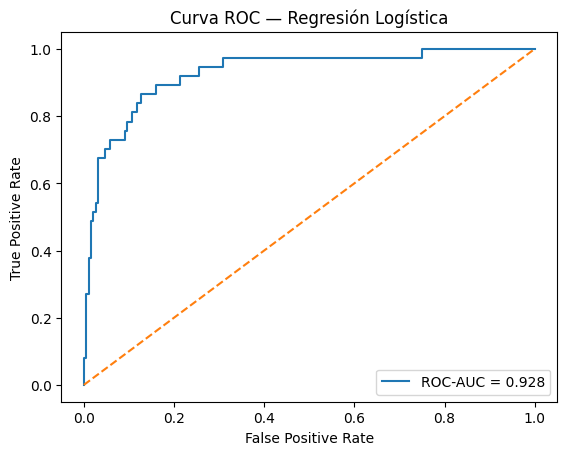

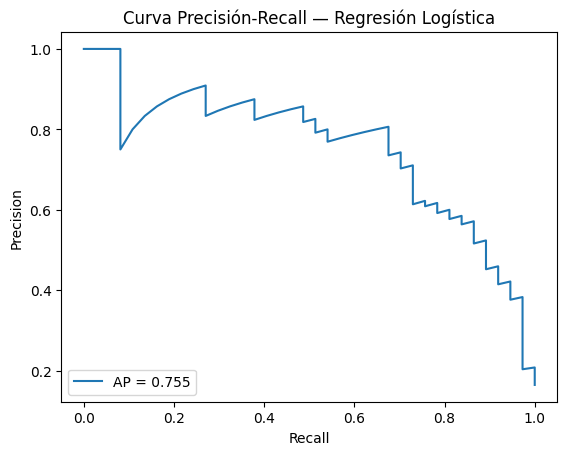

Umbral óptimo (Youden): 0.3019

Matriz de confusión:
 [[164  24]
 [  5  32]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9704    0.8723    0.9188       188
           1     0.5714    0.8649    0.6882        37

    accuracy                         0.8711       225
   macro avg     0.7709    0.8686    0.8035       225
weighted avg     0.9048    0.8711    0.8808       225

Accuracy:  0.8711
Precision: 0.5714
Recall:    0.8649
F1:        0.6882


In [13]:
# Probabilidades y predicciones para conjunto de prueba
y_proba = clf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
ap  = average_precision_score(y_test, y_proba)
print(f'ROC-AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')

# Curva ROC
fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC-AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC — Regresión Logística')
plt.legend(loc='lower right')
plt.show()

# Curva Precisión-Recall
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precisión-Recall — Regresión Logística')
plt.legend(loc='lower left')
plt.show()

# Selección de umbral: maximizando J de Youden (TPR - FPR)
youden   = tpr - fpr
best_idx = np.argmax(youden)
best_thr = thr[best_idx]
print(f'Umbral óptimo (Youden): {best_thr:.4f}')

y_pred = (y_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred)
print('\nMatriz de confusión:\n', cm)
print('\nReporte de clasificación:\n', classification_report(y_test, y_pred, digits=4))

# Métricas con formato (sin .round())
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1:        {f1_score(y_test, y_pred):.4f}")


## 8) Importancia de características (coeficientes)

In [14]:

# Extrae nombres de features finales del preprocesador
ohe = clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out(categorical_features)) if categorical_features else []
final_feature_names = numeric_features + cat_names

coef = clf.named_steps['model'].coef_.ravel()
coef_df = pd.DataFrame({'feature': final_feature_names, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(25)  # top 25
display(coef_df[['feature','coef']])


,feature,coef
4,Num_Sites,2.112564
1577,"Location_335 Dyer Shoals Port Patricia, PR 844...",1.347098
2107,Company_Campbell and Sons,1.347098
19,Names_Alexis Hill,1.347098
1074,Onboard_date_2012-03-24 16:13:42,1.347098
1954,"Location_PSC 1001, Box 5072 APO AP 43490",1.082106
759,Onboard_date_2007-02-17 15:33:59,1.082106
2608,Company_Taylor-Vaughn,1.082106
537,Names_Randy Hayes,1.082106
2283,"Company_Hatfield, Johnson and George",1.066681


## 9) Validación cruzada 

In [15]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
print('ROC-AUC CV (5-fold):', np.round(cv_scores, 4), ' | mean =', np.round(cv_scores.mean(),4))


ROC-AUC CV (5-fold): [0.9102 0.9378 0.8922 0.8387 0.9209]  | mean = 0.9


## 10) Scoring de **clientes nuevos** y recomendación de Account Manager

In [ ]:
OUTPUT_SCORES = 'predicciones_clientes_nuevos.csv'
OUTPUT_TOP    = 'prioridad_clientes_con_manager.csv'

if df_new is None:
    print('No hay archivo de clientes nuevos, salta scoring.')
else:
    missing_cols = [c for c in X.columns if c not in df_new.columns]
    for c in missing_cols:
        df_new[c] = np.nan
    df_new_aligned = df_new[X.columns].copy()

    for c in numeric_features:
        df_new_aligned[c] = pd.to_numeric(df_new_aligned[c], errors='coerce')

    for c in categorical_features:
        df_new_aligned[c] = df_new_aligned[c].astype('object')
    try:
        import pandas as pd, numpy as np
        df_new_aligned = df_new_aligned.replace({pd.NA: np.nan})
    except Exception:
        pass

    proba_new = clf.predict_proba(df_new_aligned)[:, 1]
    df_out = df_new.copy()
    df_out['prob_abandono'] = proba_new
    df_out = df_out.sort_values('prob_abandono', ascending=False)

    top_k = max(1, int(math.ceil(0.2 * len(df_out))))
    df_out['recomendacion_manager'] = 0
    df_out.iloc[:top_k, df_out.columns.get_loc('recomendacion_manager')] = 1

    # 5) Exportar
    df_out.to_csv(OUTPUT_SCORES, index=False)
    df_out.head(25).to_csv(OUTPUT_TOP, index=False)
    print(f'Archivo con puntuaciones guardado en: {OUTPUT_SCORES}')
    print(f'Archivo con priorización (top 25 mostrados / top 20% marcados) en: {OUTPUT_TOP}')
    display(df_out.head(10))


Archivo con puntuaciones guardado en: predicciones_clientes_nuevos.csv
Archivo con priorización (top 25 mostrados / top 20% marcados) en: prioridad_clientes_con_manager.csv


,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Onboard_date_year,Onboard_date_month,Onboard_date_day,Onboard_date_days_since_min,prob_abandono,recomendacion_manager
Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,NaN,NaN,NaN,NaN,NaN,1.000000,1
Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,NaN,NaN,NaN,NaN,NaN,1.000000,1
Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,NaN,NaN,NaN,NaN,NaN,1.000000,0
Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,NaN,NaN,NaN,NaN,NaN,1.000000,0
Jessica Drake,22.0,8445.26,1,3.46,14.0,2011-02-04 19:29:27,1148 Tina Stravenue Apt. 978 South Carlos TX 2...,Parks-Robbins,NaN,NaN,NaN,NaN,NaN,1.000000,0
Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,NaN,NaN,NaN,NaN,NaN,0.999292,0


## 11) Guardado del *pipeline* entrenado

In [20]:

import joblib
MODEL_PATH = 'modelo_logistico_churn.joblib'
joblib.dump(clf, MODEL_PATH)
print('Modelo guardado en:', MODEL_PATH)


Modelo guardado en: modelo_logistico_churn.joblib


# Interpretaciones

El modelo hace un buen trabajo separando a quienes se irían de quienes se quedarían (el puntaje general es alto). Con el punto de corte elegido, detecta a la gran mayoría de los que podrían abandonar, aunque entre las alertas también se cuelan varios que al final no se van. La exactitud total se ve bien, pero no es lo más importante porque hay muchos más clientes que se quedan que los que se van. Llama la atención que el número de sitios y algunos datos como fechas, empresas o ubicaciones pesen mucho; eso puede esconder patrones muy específicos del archivo y conviene tratarlos con más cuidado.

# Conclusiones

El modelo de regresión logística presenta buen poder discriminativo (ROC-AUC ≈ 0.928) y desempeño útil en la clase positiva bajo el umbral de Youden (t ≈ 0.302): recall ≈ 0.865, precision ≈ 0.571, F1 ≈ 0.688 y accuracy ≈ 0.871 con matriz de confusión [TN=164, FP=24, FN=5, TP=32]. Para operación, conviene optimizar el umbral con un esquema costo-sensible (minimizar C_FN·FN + C_FP·FP) o maximizar métricas como Fβ según prioridad de recall, y calibrar probabilidades (Platt o Isotonic) si se usarán como score de riesgo. Se recomienda reforzar el preprocesamiento: eliminar la fecha cruda y sustituirla por derivadas (año/mes/antigüedad), controlar la alta cardinalidad de Company/Location/Names con hashing o target encoding con validación cruzada anidada, y evaluar regularización L1/L2 (y selección de variables) para reducir varianza y multicolinealidad. Validar robustez con CV estratificada y, si hay temporalidad, con time-series split para prevenir leakage. Comparar contra baselines no lineales (árboles, Random Forest, XGBoost) y contra una logística con calibración y ajuste fino de class_weight/reestrategias de reamuestrado (SMOTE/undersampling). Finalmente, instrumentar monitoreo de deriva (PSI, cambio de AUC/AP) y reentrenos periódicos para mantener la estabilidad del modelo en producción.
